In [1]:
# !pip install category_encoders

import pandas as pd
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder

C:\Users\vireq\AppData\Local\Temp\ipykernel_26532\264552893.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
try:
    # URL = 'https://raw.githubusercontent.com/markovetsu/ds_projects/main/math_for_data_analysis/main/PCA/data.csv'
    # df = pd.read_csv(URL)
    df = pd.read_csv(r"C:\Users\vireq\Downloads\dataset.csv")
except:
    print('Smt went wrong! Please check and correct your url-request!')

In [3]:
df.drop_duplicates(inplace=True)

In [4]:
X, y = df.drop(["Severity"], axis=1), df["Severity"]


all_features = X.columns
binary_features = X.columns[X.dtypes == 'bool']
cat_features = X.columns[X.dtypes == 'object']
float_features = X.columns[(X.dtypes == 'float64')]
num_features = X.columns[(X.dtypes == 'int64') | (X.dtypes == 'float64')]

X[binary_features] = X[binary_features] * 1.0

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [6]:
results = {}

In [7]:
# Pipeline 1
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=cat_features)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

mse = mean_squared_error(y_test, preds)
results['Initial'] = mse
print("MSE: ", mse)

MSE:  0.8246748836251262


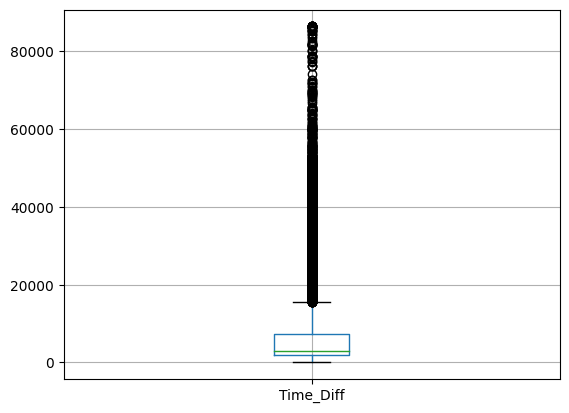

In [8]:
X_train.boxplot(column='Time_Diff')
plt.show()

In [9]:
# Custom transformer for removing outliers using IQR
class OutlierRemoverTransformer:
    def __init__(self, num_features, multiplier=0.5):
        self.num_features = num_features
        self.multiplier = multiplier

    def fit(self, X, y=None):
        Q1 = X[self.num_features].quantile(0.25)
        Q3 = X[self.num_features].quantile(0.75)
        IQR = Q3 - Q1
        self.lower_bound = Q1 - self.multiplier * IQR
        self.upper_bound = Q3 + self.multiplier * IQR

        return self

    def transform(self, X, y=None):
        X = X.copy()
        X[self.num_features] = X[self.num_features].clip(self.lower_bound, self.upper_bound, axis=1)
        return X


In [10]:
# Pipeline 2 with IQR
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=cat_features)),
    ('outlier_remover', OutlierRemoverTransformer(float_features)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

mse = mean_squared_error(y_test, preds)
results['IQR'] = mse
print("MSE: ", mse)

MSE:  0.7615816491654853


In [11]:
# Pipeline 3 with VarianceThreshold
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=cat_features)),
    ('outlier_remover', OutlierRemoverTransformer(float_features)),
    ('variance_removal', VarianceThreshold(0.9*(1-0.9))),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

mse = mean_squared_error(y_test, preds)
results['Variance'] = mse
print("MSE: ", mse)

MSE:  0.6573908550727335


In [12]:
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=cat_features)),
    ('outlier_remover', OutlierRemoverTransformer(float_features)),
    ('scaler', StandardScaler()),
])

pipeline.fit(X_train, y_train)
X_scaled = pipeline.transform(X_train)
X_test_scaled = pipeline.transform(X_test)



In [13]:
pca = PCA()
pca.fit(X_scaled)

PCA()

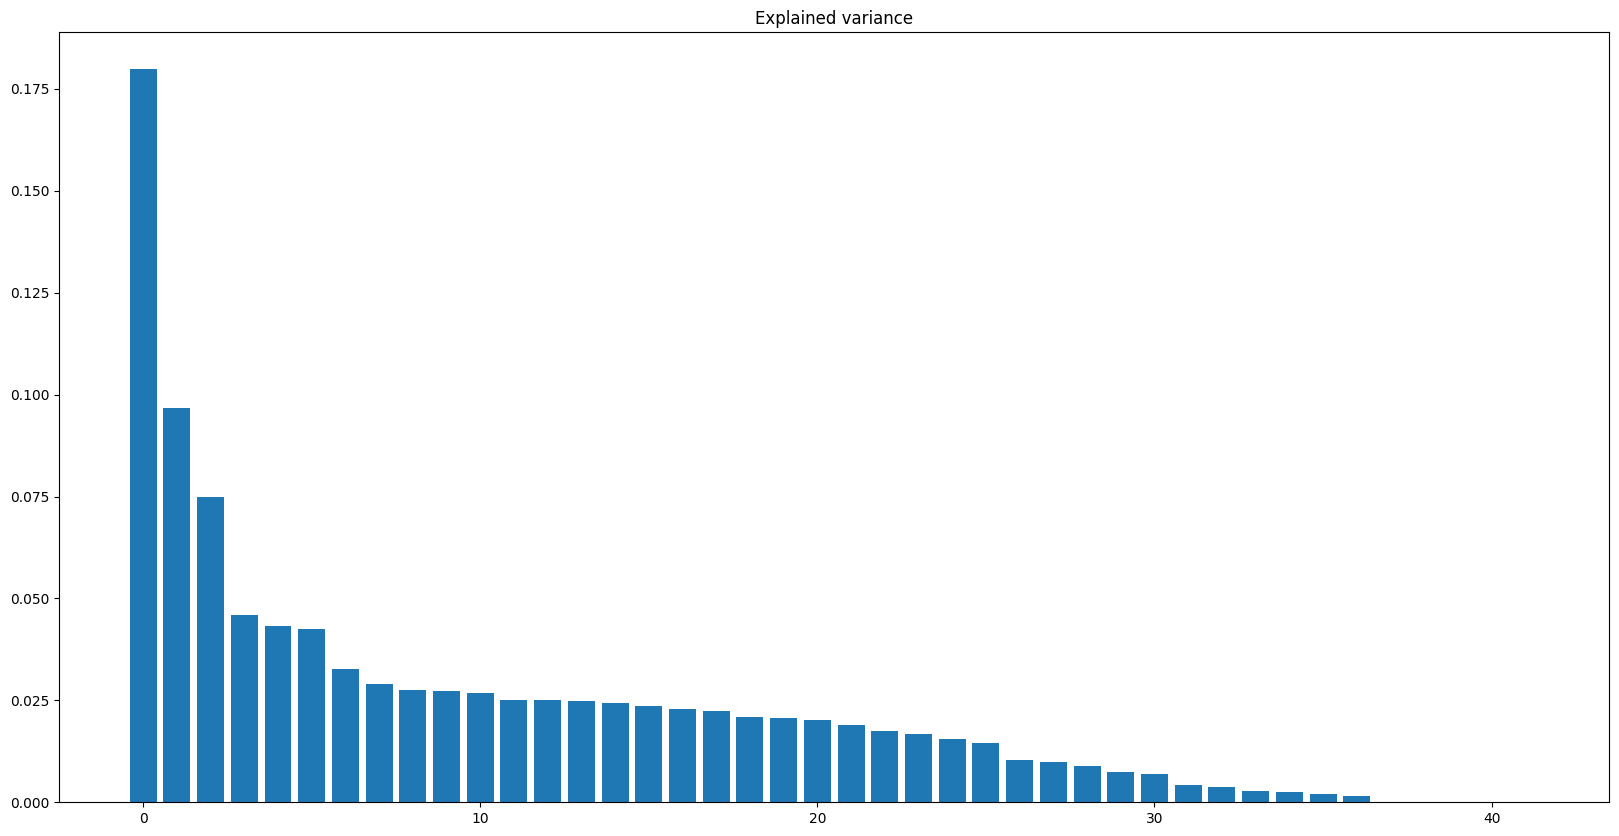

In [14]:
plt.figure(figsize=(20,10))
plt.bar(list(range(len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_)
plt.ylim(0)
plt.title('Explained variance')
plt.show()

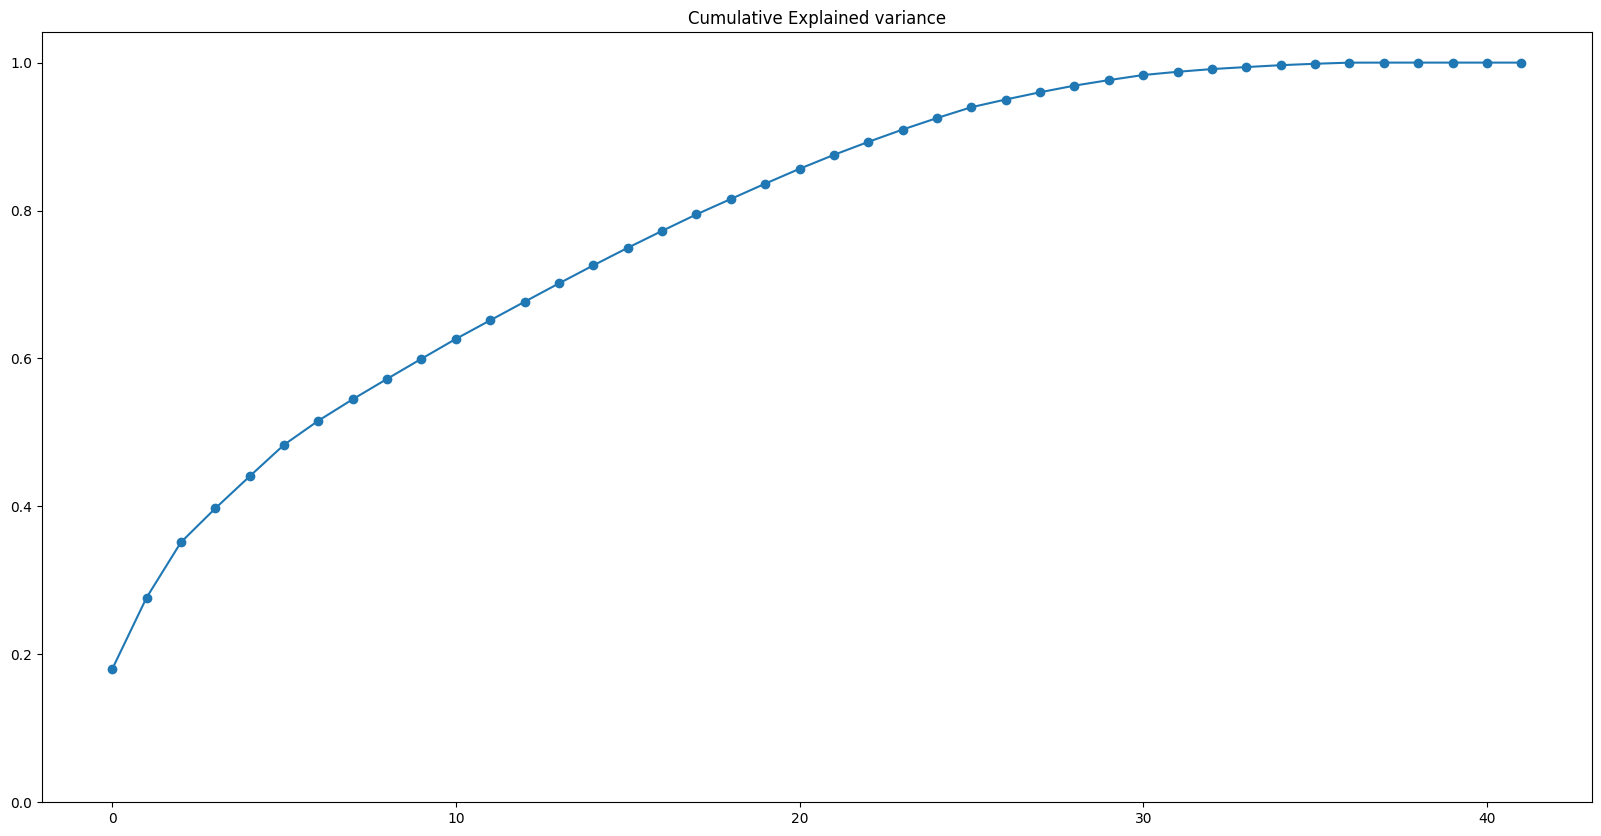

In [15]:
plt.figure(figsize=(20,10))
plt.plot(list(range(len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_.cumsum(), '-o')
plt.ylim(0)
plt.title('Cumulative Explained variance')
plt.show()

In [16]:
pd.DataFrame(pca.components_, columns=all_features).T.round(3)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
Start_Lat,-0.184,-0.002,0.436,-0.042,-0.035,0.100,0.058,-0.035,0.059,-0.076,...,0.057,-0.083,0.000,0.000,-0.001,0.000,0.707,0.004,-0.000,-0.000
Start_Lng,-0.172,-0.246,-0.320,-0.264,0.005,0.010,-0.124,-0.017,0.090,0.050,...,0.162,-0.277,-0.007,0.015,0.003,-0.001,0.004,-0.707,-0.000,0.000
End_Lat,-0.184,-0.002,0.436,-0.042,-0.035,0.100,0.058,-0.035,0.059,-0.076,...,0.057,-0.083,0.000,0.000,-0.001,-0.000,-0.707,-0.004,0.000,-0.000
End_Lng,-0.172,-0.246,-0.320,-0.264,0.005,0.010,-0.124,-0.017,0.090,0.050,...,0.162,-0.277,-0.007,0.015,0.003,-0.001,-0.004,0.707,0.000,-0.000
Distance(mi),-0.160,0.009,-0.050,0.309,-0.029,-0.006,0.106,0.058,-0.049,0.168,...,-0.033,-0.004,-0.005,0.004,0.001,0.001,0.000,-0.000,0.000,0.000
Side,0.004,0.012,-0.007,0.053,-0.021,0.010,0.059,-0.134,0.298,0.026,...,-0.001,-0.002,-0.002,0.002,0.001,0.000,0.000,-0.000,0.000,0.000
City,-0.302,-0.129,0.050,0.087,-0.064,0.135,0.069,0.093,-0.000,0.001,...,-0.551,-0.523,0.004,0.052,-0.010,0.002,0.000,-0.000,0.000,-0.000
County,-0.310,-0.142,0.055,0.030,-0.072,0.155,0.053,0.095,0.035,0.004,...,0.434,0.229,-0.004,0.645,-0.001,-0.002,-0.000,0.000,0.000,0.000
State,-0.302,-0.179,0.068,-0.109,-0.037,0.109,0.014,0.003,0.062,-0.035,...,-0.339,0.077,0.008,0.056,-0.008,0.003,-0.000,0.000,0.000,0.000
Zipcode,-0.271,-0.092,0.032,0.119,-0.055,0.099,0.096,0.127,-0.053,0.081,...,0.093,0.090,-0.001,0.017,-0.006,-0.000,-0.000,-0.000,0.000,-0.000


In [17]:
# Pipeline 4 with PCA
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols = cat_features)),
    ('outlier_remover', OutlierRemoverTransformer(float_features)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=20)),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

mse = mean_squared_error(y_test, preds)
results['PCA'] = mse
print("MSE: ", mse)

MSE:  0.618398445085454


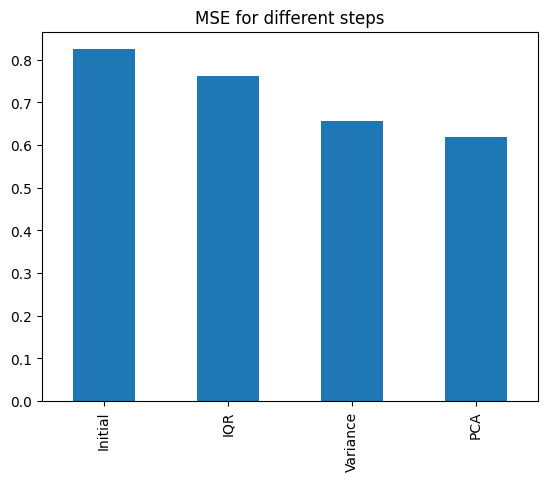

In [18]:
results = pd.Series(results)
results.plot(kind='bar', title='MSE for different steps')
plt.show()